# Detecting burning areas for antrophogenic origin

este notebook contem o fluxo de dados para descagerrar , processar e classificar as areas quema en areas de cultivo.

os modelos usados para classificação de colheita são
1. 07_modelos/model1_colheita_vr_20JLR_20200731.pkl
2. 

In [15]:
%load_ext autoreload
%autoreload 2
%config Completer.use_jedi = False
from cubo_idgeo.cubo import CuboDeDados, Mosaico
from cubo_idgeo.utils import baixar_medicoes_selecionadas
from geodata.geo_objects import BBox
from geodata import VectorData
from geodata.srs_utils import epsg_para_wkt
from datetime import date
import os
import geopandas as gpd
from osgeo import gdal
import joblib
from sklearn.ensemble import RandomForestClassifier
from time import perf_counter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import skimage.io as io
import numpy as np
import rasterio as rio
import geopandas as gpd
from rasterio.plot import show
from rasterio.mask import mask
import datetime
import time
from time import strftime,gmtime
import pandas as pd
from shapely.geometry import Polygon
from shapely.ops import cascaded_union
from itertools import combinations
from time import gmtime, strftime, time
from sentinelsat import SentinelAPI, read_geojson, geojson_to_wkt
from shapely.geometry import box, mapping
import zipfile
import shutil
import glob
from joblib import Parallel, delayed
import multiprocessing
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from rasterstats import zonal_stats
import seaborn as sns
import matplotlib.pyplot as plt
from osgeo import ogr, osr
import rioxarray as rxr
import fiona
import skimage.io as io
from skimage.feature import greycomatrix, greycoprops


os.chdir('/..)
from funcoes import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
# monta os diretorios

os.mkdir('queimada/01_shapes')
os.mkdir('queimada/01_shapes/reclassificado')
os.mkdir('queimada/02_corte')
os.mkdir('queimada/03_download')
os.mkdir('queimada/04_vtr')
os.mkdir('queimada/05_classificacao')
os.mkdir('queimada/06_estatisticas')
os.mkdir('queimada/07_modelos')


In [16]:
#configuracoes
# Pesquisa/los_balcanes/colheita/geral/01_shapes/classe_20JLR_20200731.geojson
shp_base            = '01_shapes/talhoes_analise_114.geojson'            # shape de entrada
tipo_class          = 'colheita'                                     # tipo da classificacao:
data_class          = '20210530'                                     # data da classificacao
model               = '07_modelos/model1_colheita_vr_20JLR_20200731.pkl'           # modelo treinado que sera utilizado para classificar
modelos_status      = '07_modelos/mod20210531_status_colheita_20200731.pkl' # modelo treinado para determinar status
pasta_shape         = '01_shapes/'                             # pasta com as amostras
tiff_corte          = '02_corte'                               # diretorio dos recortes
pasta_download      = '03_download/'                           # diretorio com as cenas
pasta_vtr           = '04_vtr/'                                # pasta com os vtr das bandas 2 3 4 8 paracada cena
pasta_classificacao = '05_classificacao3/'                      # pasta com a mascara binaria da classificação de colheita
pasta_est           = '06_estatisticas'                        # pasta onde sera inserido as estatisticas zonais

# download das cenas
# quadriculas_desejadas = ['20JKR', '20JLR']
# bandas_desejadas      = ['B02', 'B03', 'B04', 'B08']

# bbox = VectorData(shp_base).get_bbox()
# meu_cubo = CuboDeDados(bbox, (date(2020, 10, 18), date(2020, 10, 19)), "cubo/queimadas_treino.cubo")
# índice = meu_cubo.índice_de_medições

In [12]:
# baixar_cenas(bandas_desejadas, quadriculas_desejadas, índice, pasta_download)

  0%|          | 0/4 [00:00<?, ?img/s]

20JKR
2020-10-19 2020-10-19
Baixando...


  0%|          | 0/4 [00:00<?, ?img/s]

4 arquivos baixados 0.73 GiB, 0 já existentes.
20JLR
2020-10-19 2020-10-19
Baixando...


100%|██████████| 4/4 [00:31<00:00,  7.97s/img]

4 arquivos baixados 0.82 GiB, 0 já existentes.
Concluido!


### codigo
`# download das cenas
quadriculas_desejadas = ['20JKR', '20JLR']
bandas_desejadas      = ['B02', 'B03', 'B04', 'B08']

bbox = VectorData(shp_base).get_bbox()
meu_cubo = CuboDeDados(bbox, (date(2020, 9, 23), date(2020, 9, 24)), "queimada/lucas/treino.cubo")
índice = meu_cubo.índice_de_medições `

In [15]:
# empilhado(pasta_download, pasta_vtr)

empilhado
S2B_20JLR_20201019_0_L2A_B02.tif
S2B_20JLR_20201019_0_L2A_B03.tif
S2B_20JLR_20201019_0_L2A_B04.tif
S2B_20JLR_20201019_0_L2A_B08.tif
Empilhar completo


In [34]:
treinarModelo(shp_base, pasta_vtr, tipo_class, model)

01_shapes/classe_20JLR_20200731.geojson
Treinamento Finalizado


In [56]:
def classificar2(cam_entra, model, pasta_classificacao, tipo_class, data_class):
    """
    Funcao para classificar uma imagem
    :param cam_entra: pasta onde estao os vtr (04_vtr)
    :param model: modelo a ser carregado
    :param pasta_classificacao: pasta onde a imagem classificada sera armazenada
    :param tipo_class: tipo da classificacao (str)
    :param data_class: data da classificacao (str)
    :return:
    """

    print(f'Modelo carregado: {model}')
    classifier = joblib.load(model)
    list_folders = []
    # 	for root, dirs, files in os.walk(cam_entra):

    # 		for tiff in files:

    try:
#         naip_fn = os.path.join(root, tiff)
        naip_fn = pasta_vtr

        print(pasta_vtr)

        img_ds = io.imread(pasta_vtr)
        img = np.array(img_ds, dtype='int16')
        xshape = img[:, :, 0].shape

        # aqui tento dividir em 2x2
        block_img = np.zeros(xshape)
        im_h, im_w = img.shape[:2]
        bl_h, bl_w = int(im_h / 2), int(im_w / 2)
        for row in np.arange(im_h - bl_h + 1, step=bl_h):
            for col in np.arange(im_w - bl_w + 1, step=bl_w):
                new_image = img[row:row + bl_h, col:col + bl_w]
                new_shape = new_image.shape[0] * new_image.shape[1], new_image.shape[2]
                img_as_array = new_image[:, :, :4].reshape(new_shape)

                start_time = time()

                class_prediction = classifier.predict(img_as_array)
                class_prediction = class_prediction.reshape(new_image[:, :, 0].shape)

                block_img[row:row + bl_h, col:col + bl_w] = class_prediction
                print("--- %s seconds ---" % (time() - start_time))

        driverTiff = gdal.GetDriverByName('GTiff')
        naip_ds = gdal.Open(naip_fn)
        nbands = naip_ds.RasterCount

        classification = os.path.join(pasta_classificacao, f'classificadaXX_{tipo_class}_{data_class}' + '.tiff')
        classification_ds = driverTiff.Create(classification, naip_ds.RasterXSize, naip_ds.RasterYSize,
                                              1, gdal.GDT_UInt16)
        classification_ds.SetGeoTransform(naip_ds.GetGeoTransform())
        classification_ds.SetProjection(naip_ds.GetProjectionRef())
        classification_ds.GetRasterBand(1).SetNoDataValue(255)

        classification_ds.GetRasterBand(1).WriteArray(block_img)
        classification_ds = None
        naip_ds = None
        print('terminou')

    except Exception as e:
        print(e)
    print('Classificado')

In [57]:
classificar2(pasta_vtr, model, pasta_classificacao, tipo_class, data_class)

Modelo carregado: 07_modelos/model1_colheita_vr_20JLR_20200731.pkl
04_vtr/S2B_20JLR_20200731_0_L2A.tif
--- 3.392266273498535 seconds ---
--- 3.4554474353790283 seconds ---
--- 3.474261999130249 seconds ---
--- 3.406390428543091 seconds ---
terminou
Classificado


# Construindo a linha temporal

In [ ]:
recortar_vtrs('03_download','talhoes_analise_114.geojson')

In [ ]:
empilhado('geral/03_download/', 'geral/04_vtr')

In [62]:
classificar(pasta_vtr, model, pasta_classificacao, 'colheita', data_class)

In [17]:
# para gerar o status da colheita



from skimage.transform import resize

def normalize(array):
    """Normalizes numpy arrays into scale 0.0 - 1.0"""
    array_min, array_max = array.min(), array.max()
    return ((array - array_min)/(array_max - array_min))

def vr_status(caminho_shp, caminho_classificada, modelos_status):
    '''
    Cria o estado cana, parcial, colhido para cada talhao , a partir de uma cena clasificada
    '''
    # carrega o modelo status
    classifier = joblib.load(modelos_status)
    
    # leitura do shp Base
    areas = gpd.read_file(caminho_shp) # leitura do shp 
    areas = areas.to_crs(epsg='4326') # confirma o proj

    gdf = gpd.GeoDataFrame() # geoDataFrame vacio para construir o shp de saida
    imagem = list()
    label = list()

    # lista que contem as classificadas
    tiles = list()
    for root, dirs, files in os.walk(caminho_classificada, topdown=True): # itera o diretorio de classificação

        for item in files:
            print(item)
            if 'tiff' in item: # filtrinho para pular um tiff 
                pass

            for i , area in areas.iterrows(): # itera em cada talhao
        #             
                try:

                    caminho = root+item # caminho a classificada
                    ids = str(area.id_ta) # id_ta 
                    data = item[10:-10] # data da cena
        #                
                    # esta parte é foda...

                    # pega a geometria da area no caso cada poligono                                    
                    g_source = gpd.GeoSeries(area.geometry)  
                    # seta a projeção original da area epsg:4623
                    proj_area = '+init='+ str(areas.crs)
                    # como a serie não tem crs , setamos essa projeção
                    g_source.crs = (proj_area)
                    # abre o raster da classificação

                    colheita_raster = rio.open(caminho)
                    # pega a projeção da classificação
                    proj_tile = '+init='+str(colheita_raster.crs)
                    # reprojetao vectorial da area para a proj do raster
                    g_source = g_source.to_crs(proj_tile)
                    # corta o raster pelo poligono
                    out_img, out_transform  = mask(dataset=colheita_raster, \
                                          shapes=g_source, crop=True , nodata=255)
                    # copia os metadados do raster
                    out_meta = colheita_raster.meta.copy() 
                    # atualiza a nova largura e anchura da imagem
                    out_meta.update({"driver": "GTiff",
                                    'nodata': 255,
                                     "height": out_img.shape[1],
                                     "width": out_img.shape[2],
                                     "transform": out_transform,
                                     })
                    # define um diretorio com o nome do tileid
                    new_path = '02_corte4_tr/' +  item[:-4] + '_'
                # verifica se o diretorio existe
                #             if not os.path.exists(new_path):
                #                 # se não existe crio ele
                #                 os.makedirs(new_path)


                    # guarda o recorte... infelizmente tem que guardar no hd
                    with rio.open(new_path + ids +'.tif', "w", **out_meta) as dest:
                    #                 dest.write(subset[0], 1)
                        dest.write(out_img)

                    # leituda do corte anterior
                    with rio.open(new_path + ids +'.tif') as src:
                        # copi o metadados do recorte
                        subset_meta = src.meta.copy()
                    #   # instacia  a banda 1 onde fica a classe                          
                        red = src.read(1, masked=True)
                    # fecha o corte
                    src.close
                    # reformata o corte do talhao para 100x100 px
                    resized = resize(red, (100, 100),mode='constant', cval=255 , clip=True)
                    # passa a mascara 
                    binaria = np.ma.masked_array(resized, mask=(resized == 0))
        #           # reordena o array do talhao para entrar no classificador
                    new = binaria.reshape((1, -1))
                    # o classificador faz a predição
                    status = classifier.predict(new)
                    # pegamos as probabilidades para cada classe
                    prop = classifier.predict_proba(new)
            #       # estrutura os dados para cada talhao array
                    area['data'] = data
                    area['status']= status[0]
                    area['prop_cana'] = prop[0][0]
                    area['prop_colhido'] = prop[0][1]
                    area['prop_parcial'] = prop[0][2]
                    # cagerra no geodataframe
                    gdf = gdf.append(area)
    

                except Exception as e:

                    print(e)
                
    return gdf

In [1]:

geo_estatus = vr_status(shp_base, pasta_classificacao , modelos_status=modelos_status)
geo_estatus.to_file('10_saidas_shp/GLB_VR_colheita.shp')
# estatisticas(shp_base, pasta_est, 'colheita', '20200506', pasta_classificacao, 'geral/07_modelos/model_GLB_Colheita_Status_20210510.pkl')

NameError: name 'vr_status' is not defined

In [48]:
geo_estatus

,data,fazenda,geometry,id_ta,prop_cana,prop_colhido,prop_parcial,status
167,daXX_colheita_20210530S2B_20JLR_20200601,,"MULTIPOLYGON (((-65.01825 -26.92764, -65.01737...",1412001,0.53,0.47,0.0,cana
168,daXX_colheita_20210530S2B_20JLR_20200601,,"MULTIPOLYGON (((-65.01431 -26.95949, -65.01930...",2102001,0.53,0.47,0.0,cana
169,daXX_colheita_20210530S2B_20JLR_20200601,,"MULTIPOLYGON (((-65.01366 -26.92852, -65.01498...",1412002,0.53,0.47,0.0,cana
170,daXX_colheita_20210530S2B_20JLR_20200601,,"MULTIPOLYGON (((-65.01507 -26.89347, -65.01224...",1632001,0.53,0.47,0.0,cana
171,daXX_colheita_20210530S2B_20JLR_20200601,,"MULTIPOLYGON (((-65.01433 -26.90846, -65.01373...",1412003,0.53,0.47,0.0,cana
...,...,...,...,...,...,...,...,...
1126,daXX_colheita_20210530S2A_20JLR_20201123,,"MULTIPOLYGON (((-64.74480 -26.66753, -64.74483...",2481016,0.53,0.47,0.0,cana
1127,daXX_colheita_20210530S2A_20JLR_20201123,,"MULTIPOLYGON (((-64.74897 -26.67402, -64.74863...",2481012,0.53,0.47,0.0,cana
1128,daXX_colheita_20210530S2A_20JLR_20201123,,"MULTIPOLYGON (((-64.86131 -26.66035, -64.86180...",1611004,0.53,0.47,0.0,cana
1129,daXX_colheita_20210530S2A_20JLR_20201123,,"MULTIPOLYGON (((-64.70282 -26.73935, -64.70330...",1523003,0.53,0.47,0.0,cana


In [67]:
jun = geo_estatus[geo_estatus['data'] == '20200016']
# jul  = geo_estatus[geo_estatus['data'] == '20200716']
# ago  = geo_estatus[geo_estatus['data'] == '20200820']
# setm = geo_estatus[geo_estatus['data'] == '20200909']
# out  = geo_estatus[geo_estatus['data'] == '20201019']
# nov  = geo_estatus[geo_estatus['data'] == '20201123']
#dez  = geo_estatus[geo_estatus['data'] == '20201208']

# jul.to_file('11_shp_classif/jul/julho.shp')
# ago.to_file('11_shp_classif/ago/agosto.shp')
# setm.to_file('11_shp_classif/set/setembro.shp')
# out.to_file('11_shp_classif/out/outubro.shp')
# nov.to_file('11_shp_classif/nov/novembro.shp')
#dez.to_file('11_shp_classif/dez/dezembro.shp')


<ipython-input-67-78b798791ead>:13: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  dez.to_file('11_shp_classif/dez/dezembro.shp')


In [269]:
# teste status colheita
zs_tabela = 'geral/06_estatisticas/zs_colheita_20200506.csv'
modelo_status ='geral/07_modelos/model03_GLB_Colheita_20210510.pkl'
pasta_saida = 'geral/06_estatisticas/'
definir_status(zs_tabela, modelo_status, pasta_saida)

terminado, status:


1231001


<ipython-input-47-7d354112ab0d>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  talhao['data'] = talhao['data'].astype(str)


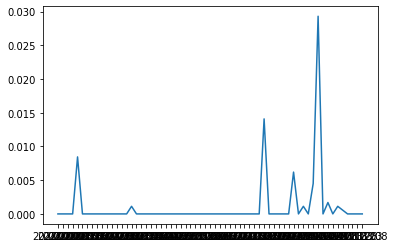

In [47]:
#df = pd.read_csv('geral/06_estatisticas/zs_colheita_20200506.csv')
#df = df[df['count'] > 0]
id_talhao = list(df['id_ta'].unique())
selecao = id_talhao[101]
talhao = df[df['id_ta'] == selecao]
talhao['data'] = talhao['data'].astype(str)
print(selecao)
plt.plot(talhao['data'], talhao['mean'])

1271005


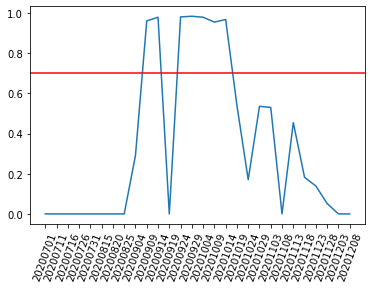

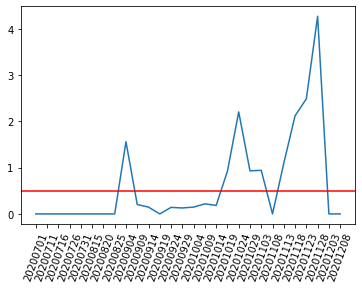

In [189]:
id_talhao = list(df['id_ta'].unique())
selecao = 1271005
talhao = df.loc[df['id_ta']==selecao][35:]
talhao['data'] = talhao['data'].astype(str)
print(selecao)
plt.plot(talhao['data'], talhao['mean'])
plt.axhline(y=0.7, color='r', linestyle='-')
plt.xticks(rotation=70)
plt.show()

plt.plot(talhao['data'], talhao['cv'])
plt.axhline(y=0.5, color='r', linestyle='-')
plt.xticks(rotation=70)
plt.show()

In [ ]:
df.loc[df['talhao_id']==1004001][[,'variancia','coeficiente_de_variacao','dia_do_ano']].head(70)

In [190]:
tabela = df.loc[df['id_ta']==selecao][35:][['mean','min','max', 'count','std','median','majority', 'cv', 'data']]
tabela.to_csv(f'geral/tabela_{selecao}.csv')
tabela


,mean,min,max,count,std,median,majority,cv,data
22877,0.000000,0.0,0.0,3061,0.000000,0.0,0.0,0.000000,20200701
22882,0.000000,0.0,0.0,3061,0.000000,0.0,0.0,0.000000,20200711
22885,0.000000,0.0,0.0,3061,0.000000,0.0,0.0,0.000000,20200716
22889,0.000000,0.0,0.0,3061,0.000000,0.0,0.0,0.000000,20200726
22892,0.000000,0.0,0.0,3061,0.000000,0.0,0.0,0.000000,20200731
22898,0.000000,0.0,0.0,3061,0.000000,0.0,0.0,0.000000,20200815
22901,0.000000,0.0,0.0,3061,0.000000,0.0,0.0,0.000000,20200820
22904,0.000000,0.0,0.0,3061,0.000000,0.0,0.0,0.000000,20200825
22908,0.291081,0.0,1.0,3061,0.454261,0.0,0.0,1.560598,20200904
22911,0.960470,0.0,1.0,3061,0.194851,1.0,1.0,0.202871,20200909


In [ ]:
for root, dirs, files in os.walk(pasta_classificacao, topdown=True):  # itera o diretorio de classificação
    contador = 0
    for dire in files:  # itera cada arquivo tiff corte
            
           

In [226]:
df_nuvem = estatisticas_nuvem('lucas/talhoes_analise_114.geojson', 'testevtr/')


epsg:4326


/media/Armazenamento/pesquisa_home/.local/lib/python3.8/site-packages/rasterstats/io.py:302: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")


terminado, areas:


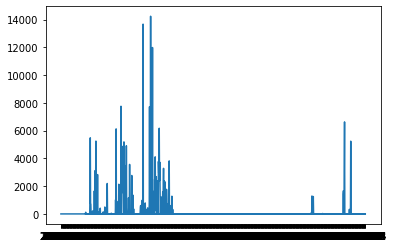

In [241]:
plt.plot(df_nuvem['id_ta'], df_nuvem['pixel_1'])

In [242]:
df_nuvem.to_csv('teste.csv')

In [272]:
status = pd.read_csv('geral/06_estatisticas/GLB_status_colheita.csv')
status[350:400].head(50)
    

,Unnamed: 0,Unnamed: 0.1,fazenda,id_ta,min,max,mean,count,std,median,majority,cv,data,dia_count,dia_count_int,status
350,517,0,0,1004003,0.0,0.0,0.000000,2163,0.000000,0.0,0.0,0.000000,2020-07-31,212 days,212,0
351,519,0,0,1004003,0.0,0.0,0.000000,2163,0.000000,0.0,0.0,0.000000,2020-08-03,215 days,215,0
352,520,0,0,1004003,0.0,0.0,0.000000,2163,0.000000,0.0,0.0,0.000000,2020-08-05,217 days,217,0
353,521,0,0,1004003,0.0,0.0,0.000000,2163,0.000000,0.0,0.0,0.000000,2020-08-08,220 days,220,0
354,522,0,0,1004003,0.0,0.0,0.000000,2163,0.000000,0.0,0.0,0.000000,2020-08-10,222 days,222,0
355,523,0,0,1004003,0.0,0.0,0.000000,2163,0.000000,0.0,0.0,0.000000,2020-08-15,227 days,227,0
356,525,0,0,1004003,0.0,0.0,0.000000,2163,0.000000,0.0,0.0,0.000000,2020-08-18,230 days,230,0
357,526,0,0,1004003,0.0,0.0,0.000000,2163,0.000000,0.0,0.0,0.000000,2020-08-20,232 days,232,0
358,528,0,0,1004003,0.0,0.0,0.000000,2163,0.000000,0.0,0.0,0.000000,2020-08-23,235 days,235,0
359,529,0,0,1004003,0.0,1.0,0.003699,2163,0.060703,0.0,0.0,16.412648,2020-08-25,237 days,237,0


In [299]:
shp_base            = 'lucas/talhoes_analise_114.geojson'            # shape de entrada
tipo_class          = 'colheita'                                     # tipo da classificacao:
data_class          = '20210505'                                     # data da classificacao
model               = 'noellen/07_modelos/model_v1_colheita.pkl'           # modelo treinado que sera utilizado para classificar
modelos_status      = 'geral/07_modelos/model_GLB_Colheita_Status_20210510.pkl' # modelo treinado para determinar status
pasta_shape         = 'geral/01_shapes/'                             # pasta com as amostras
tiff_corte          = 'geral/02_corte'                               # diretorio dos recortes
pasta_download      = 'geral/03_download/'                           # diretorio com as cenas
pasta_vtr           = 'geral/04_vtr/'                                # pasta com os vtr das bandas 2 3 4 8 paracada cena
pasta_classificacao = 'geral/05_classificacao/'                      # pasta com a mascara binaria da classificação de colheita
pasta_est           = 'geral/06_estatisticas'                        # pasta onde sera inserido as estatisticas zonais


ref_train = treinarModelo(pasta_shape, pasta_vtr, 'colheita', model)

ValueError: need at least one array to concatenate